## ⼩批量随机梯度下降
到⽬前为⽌，我们在基于梯度的学习⽅法中遇到了两个极端情况：11.3节中使⽤完整数据集来计算梯度并更
新参数，11.4节中⼀次处理⼀个训练样本来取得进展。⼆者各有利弊：每当数据⾮常相似时，梯度下降并不
是⾮常“数据⾼效”。⽽由于CPU和GPU⽆法充分利⽤向量化，随机梯度下降并不特别“计算⾼效”。这暗⽰
了两者之间可能有折中⽅案，这便涉及到⼩批量随机梯度下降（minibatch gradient descent）。

## 向量化和缓存
使⽤⼩批量的决策的核⼼是计算效率。当考虑与多个GPU和多台服务器并⾏处理时，这⼀点最容易被理解。
在这种情况下，我们需要向每个GPU发送⾄少⼀张图像。有了每台服务器8个GPU和16台服务器，我们就能得
到⼤⼩为128的⼩批量。

当涉及到单个GPU甚⾄CPU时，事情会更微妙⼀些：这些设备有多种类型的内存、通常情况下多种类型的计
算单元以及在它们之间不同的带宽限制。例如，⼀个CPU有少量寄存器（register），L1和L2缓存，以及L3缓
存（在不同的处理器内核之间共享）。随着缓存的⼤⼩的增加，它们的延迟也在增加，同时带宽在减少。可以
说，处理器能够执⾏的操作远⽐主内存接⼝所能提供的多得多。

⾸先，具有16个内核和AVX-512向量化的2GHz CPU每秒可处理⾼达2 · 109
· 16 · 32 = 1012个字节。同时，GPU的性能很容易超过该数字100倍。⽽另⼀⽅⾯，中端服务器处理器的带宽可能不超过100Gb/s，即不到处理器满
负荷所需的⼗分之⼀。更糟糕的是，并⾮所有的内存⼊⼝都是相等的：内存接⼝通常为64位或更宽（例如，在
最多384位的GPU上）。因此读取单个字节会导致由于更宽的存取⽽产⽣的代价。

其次，第⼀次存取的额外开销很⼤，⽽按序存取（sequential access）或突发读取（burst read）相对开销较
⼩。

减轻这些限制的⽅法是使⽤⾜够快的CPU缓存层次结构来为处理器提供数据。这是深度学习中批量处理背后
的推动⼒。举⼀个简单的例⼦：矩阵-矩阵乘法。⽐如A = BC，我们有很多⽅法来计算A。例如，我们可以尝
试以下⽅法：
* 我们可以计算Aij = Bi,:C⊤:,j，也就是说，我们可以通过点积进⾏逐元素计算。
* 我们可以计算A:,j = BC⊤:,j，也就是说，我们可以⼀次计算⼀列。同样，我们可以⼀次计算A⼀⾏Ai,:。
* 我们可以简单地计算A = BC。
* 我们可以将B和C分成较⼩的区块矩阵，然后⼀次计算A的⼀个区块。

如果我们使⽤第⼀个选择，每次我们计算⼀个元素Aij时，都需要将⼀⾏和⼀列向量复制到CPU中。更糟糕的
是，由于矩阵元素是按顺序对⻬的，因此当从内存中读取它们时，我们需要访问两个向量中许多不相交的位
置。第⼆种选择相对更有利：我们能够在遍历B的同时，将列向量C:,j保留在CPU缓存中。它将内存带宽需求
减半，相应地提⾼了访问速度。第三种选择表⾯上是最可取的，然⽽⼤多数矩阵可能不能完全放⼊缓存中。
第四种选择提供了⼀个实践上很有⽤的⽅案：我们可以将矩阵的区块移到缓存中然后在本地将它们相乘。让
我们来看看这些操作在实践中的效率如何。

除了计算效率之外，Python和深度学习框架本⾝带来的额外开销也是相当⼤的。回想⼀下，每次我们执⾏代
码时，Python解释器都会向深度学习框架发送⼀个命令，要求将其插⼊到计算图中并在调度过程中处理它。
这样的额外开销可能是⾮常不利的。总⽽⾔之，我们最好⽤向量化（和矩阵）。


In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

按元素分配只需遍历分别为B和C的所有⾏和列，即可将该值分配给A。


In [2]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()


0.9638752937316895

更快的策略是执⾏按列分配。

In [3]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()


0.009008169174194336

最有效的⽅法是在⼀个区块中执⾏整个操作。让我们看看它们各⾃的操作速度是多少。


In [4]:
# ⼀次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 2.075, column 222.021, full 999.358


### 小批量
之前我们会理所当然地读取数据的⼩批量，⽽不是观测单个数据来更新参数，现在简要解释⼀下原因。处理
单个观测值需要我们执⾏许多单⼀矩阵-⽮量（甚⾄⽮量-⽮量）乘法，这耗费相当⼤，⽽且对应深度学习框
架也要巨⼤的开销。这既适⽤于计算梯度以更新参数时，也适⽤于⽤神经⽹络预测。也就是说，每当我们执
⾏w ← w − ηtgt时，消耗巨⼤。其中

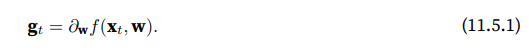

我们可以通过将其应⽤于⼀个⼩批量观测值来提⾼此操作的计算效率。也就是说，我们将梯度gt替换为⼀个
⼩批量⽽不是单个观测值

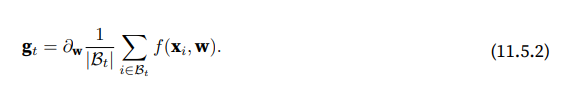

让我们看看这对gt的统计属性有什么影响：由于xt和⼩批量Bt的所有元素都是从训练集中随机抽出的，因此
梯度的期望保持不变。另⼀⽅⾯，⽅差显著降低。由于⼩批量梯度由正在被平均计算的b := |Bt|个独⽴梯度
组成，其标准差降低了b^(− 1/2) 。这本⾝就是⼀件好事，因为这意味着更新与完整的梯度更接近了。
直观来说，这表明选择⼤型的⼩批量Bt将是普遍可⾏的。然⽽，经过⼀段时间后，与计算代价的线性增⻓相
⽐，标准差的额外减少是微乎其微的。在实践中我们选择⼀个⾜够⼤的⼩批量，它可以提供良好的计算效率
同时仍适合GPU的内存。下⾯，我们来看看这些⾼效的代码。在⾥⾯我们执⾏相同的矩阵-矩阵乘法，但是这
次我们将其⼀次性分为64列的“⼩批量”。

In [5]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')


performance in Gigaflops: block 1998.715


### 读取数据集
来看看如何从数据中有效地⽣成⼩批量。下⾯我们使⽤NASA开发的测试机翼的数据集不同⻜⾏器产
⽣的噪声132来⽐较这些优化算法。为⽅便起⻅，我们只使⽤前1, 500样本。数据已作预处理：我们移除了均值
并将⽅差重新缩放到每个坐标为1。


In [6]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')
#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1


### 从零开始实现